# Giai đoạn 5 – kNN (Full feature set)

Hyperparams: k=5, weights=distance, metric=euclidean.  
Acc ≈ 0.935 ± 0.034 (cao) nhưng std lớn hơn XGBoost.  
Ưu: Không cần huấn luyện; Nhược: Suy luận chậm khi dữ liệu lớn.  
Dùng làm baseline phi tham số để kiểm tra tính ổn định feature scaling.

# Tiền xử lý ảnh
+ _prep_gray(): grayscale + downscale >700k + medianBlur(3).",
+ OCR, Histogram, ORB, Layout giống SVM full.",
+ StandardScaler áp dụng trên vector đặc trưng sau trích (không thuộc phần xử lý ảnh thô).",
+ Lưu ý: kNN nhạy scale nên chỉ chuẩn hóa ở bước feature-level, không ảnh-level."

In [6]:
import cv2, os, re, numpy as np
from skimage.metrics import structural_similarity as ssim
import pytesseract
from difflib import SequenceMatcher
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import StandardScaler     
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

pytesseract.pytesseract.tesseract_cmd = r'D:\Apps\Tesseract-OCR\tesseract.exe'

def load_cases():
    mapping = {'identical':'similar','text_changes':'almost','layout_changes':'almost',
               'changes':'different','completely_different':'different'}
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"

    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m: continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir): continue
        for vf in os.listdir(vidir):
            label = mapping.get(vf.split('.')[0].lower())
            if label: 
                cases.append((os.path.join(ori_dir,f), os.path.join(vidir,vf), label))
                groups.append(group_id)
    return cases, groups

class FeatureKNN:
    def __init__(self):
        self.model = KNeighborsClassifier(
            n_neighbors=7,          
            weights='uniform',    
            metric='manhattan',     
            algorithm='brute',       
            n_jobs=-1             
        )
        
        self.scaler = StandardScaler()
        
        self.orb = cv2.ORB_create(nfeatures=150)
        self.map = {'similar':0,'almost':1,'different':2}
        self.names = ['Similar','Almost','Different']
        self._ocr_cache = {}

    def _prep_gray(self, img):
        g=cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels=700_000
        h,w=g.shape
        if h*w>max_pixels:
            s=(max_pixels/(h*w))**0.5
            g=cv2.resize(g,(int(w*s), int(h*s)))
        g=cv2.medianBlur(g,3)
        return g

    def f_ssim(self, a, b):
        try:
            g1 = self._prep_gray(a); g2 = self._prep_gray(b)
            return ssim(g1, g2, data_range=255)
        except:
            return 0.5

    def f_ocr(self,a,b):
        def gw(p,gimg):
            if p in self._ocr_cache: return self._ocr_cache[p]
            bw=cv2.adaptiveThreshold(gimg,255,cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY,21,8)
            txt=pytesseract.image_to_string(bw, config="--oem 3 --psm 6")
            ws=re.sub(r'[^A-Za-z0-9 ]+',' ',txt).lower().split()
            self._ocr_cache[p]=ws
            return ws
        try:
            g1=self._prep_gray(a); g2=self._prep_gray(b)
            if g1 is None or g2 is None: return 0.5
            t1=gw(a,g1); t2=gw(b,g2)
            if len(t1)<3 and len(t2)<3: return 0.8
            if len(t1)==0 or len(t2)==0: return 0.3
            sm=SequenceMatcher(None,' '.join(t1),' '.join(t2)).ratio()
            jacc=len(set(t1)&set(t2))/max(len(set(t1)),len(set(t2)))
            return float(np.clip(0.7*sm+0.3*jacc,0.1,0.95))
        except: return 0.5

    def f_hist(self,a,b):
        try:
            c1=cv2.imread(a); c2=cv2.imread(b)
            if c1 is None or c2 is None: return 0.5
            bins=32
            sims=[]
            for ch in range(3):
                h1=cv2.calcHist([c1],[ch],None,[bins],[0,256])
                h2=cv2.calcHist([c2],[ch],None,[bins],[0,256])
                cv2.normalize(h1,h1,alpha=1.0,norm_type=cv2.NORM_L1)
                cv2.normalize(h2,h2,alpha=1.0,norm_type=cv2.NORM_L1)
                sims.append((cv2.compareHist(h1,h2,cv2.HISTCMP_CORREL)+1)/2)
            return float(np.mean(sims))
        except: return 0.5

    def f_orb(self,a,b):
        try:
            g1=self._prep_gray(a); g2=self._prep_gray(b)
            kp1,d1=self.orb.detectAndCompute(g1,None)
            kp2,d2=self.orb.detectAndCompute(g2,None)
            if d1 is None or d2 is None: return 0.5
            bf=cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
            knn=bf.knnMatch(d1,d2,k=2)
            good=[]
            for pr in knn:
                if len(pr)<2: continue
                m,n=pr
                if m.distance<0.75*n.distance: good.append(m)
            if not good: return 0.5
            ratio=len(good)/max(1,min(len(kp1),len(kp2)))
            quality=1 - np.mean([m.distance for m in good])/256.0
            return float(np.clip(0.5*ratio+0.5*quality,0,1))
        except: return 0.5

    def f_layout(self, a, b):
        try:
            e1 = cv2.Canny(self._prep_gray(a), 50, 150) > 0
            e2 = cv2.Canny(self._prep_gray(b), 50, 150) > 0
            inter = np.logical_and(e1, e2).sum()
            uni   = np.logical_or(e1, e2).sum()
            if uni == 0: return 1.0
            iou = inter / uni
            return float(iou)  
        except:
            return 0.5

    def feat(self,a,b):
        return [self.f_ssim(a,b), self.f_ocr(a,b), self.f_hist(a,b), self.f_orb(a,b), self.f_layout(a,b)]

    def train_eval(self, cases, groups):
        X = [self.feat(a,b) for a,b,l in cases]
        y = [self.map[l] for _,_,l in cases]
        
        gkf = GroupKFold(n_splits=5)  
        accuracies = []
        fold = 1
        
        for train_idx, test_idx in gkf.split(X, y, groups):
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]
            
            self.scaler.fit(Xtr)
            self.model.fit(self.scaler.transform(Xtr), ytr)
            yp = self.model.predict(self.scaler.transform(Xte))

            acc = (yp==yte).mean()*100
            accuracies.append(acc)
            
            print(f"Fold {fold} - kNN: {acc:.1f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold += 1

        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"\nV3 k-Nearest Neighbors Results:")
        print(f"Mean Accuracy: {mean_acc:.1f}%")
        print(f"Std Accuracy: {std_acc:.1f}%")
        
        return mean_acc, std_acc

cases, groups = load_cases()
print(f"{len(cases)} cases from {len(set(groups))} groups")
knn_model = FeatureKNN()
knn_mean, knn_std = knn_model.train_eval(cases, groups)

300 cases from 60 groups
Fold 1 - kNN: 88.3%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       0.87      0.83      0.85        24
   Different       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.88      0.88      0.88        60

[[12  0  0]
 [ 0 20  4]
 [ 0  3 21]]
Fold 2 - kNN: 88.3%
              precision    recall  f1-score   support

     Similar       1.00      1.00      1.00        12
      Almost       0.84      0.88      0.86        24
   Different       0.87      0.83      0.85        24

    accuracy                           0.88        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.88      0.88      0.88        60

[[12  0  0]
 [ 0 21  3]
 [ 0  4 20]]
Fold 3 - kNN: 93.3%
              precision    recall  f1-score   support

     Similar       0.92 

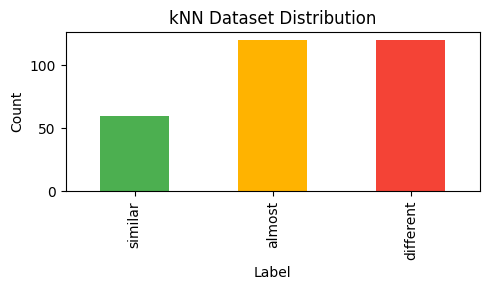

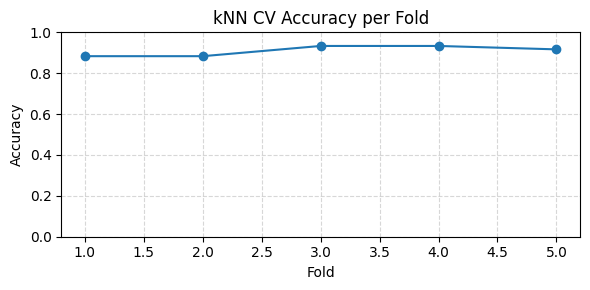

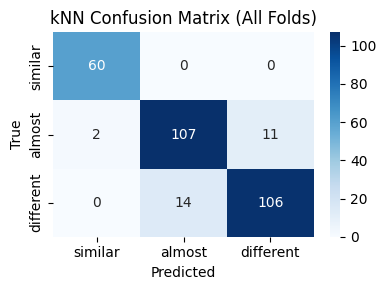

In [7]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score

def build_feature_df_knn(model, cases, groups):
    rows=[]
    for (a,b,l), g in zip(cases, groups):
        f = model.feat(a,b)
        rows.append({'SSIM':f[0],'OCR':f[1],'Hist':f[2],'ORB':f[3],'Layout':f[4],
                     'label':l,'group':g})
    return pd.DataFrame(rows)

if 'df_knn' not in globals():
    df_knn = build_feature_df_knn(knn_model, cases, groups)

label_order = ['similar','almost','different']
feat_cols = ['SSIM','OCR','Hist','ORB','Layout']

plt.figure(figsize=(5,3))
df_knn['label'].value_counts().reindex(label_order).plot(kind='bar',
    color=['#4caf50','#ffb300','#f44336'])
plt.title('kNN Dataset Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

gkf = GroupKFold(n_splits=5)
X_all = df_knn[feat_cols].values
y_all = df_knn['label'].values
accs=[]; all_true=[]; all_pred=[]
inv_map = {v:k for k,v in knn_model.map.items()}

for fold,(tr,te) in enumerate(gkf.split(X_all, y_all, groups),1):
    Xtr, Xte = X_all[tr], X_all[te]
    ytr, yte = y_all[tr], y_all[te]

    knn_model.scaler.fit(Xtr)
    knn_model.model.fit(knn_model.scaler.transform(Xtr),
                        [knn_model.map[l] for l in ytr])
    yp_int = knn_model.model.predict(knn_model.scaler.transform(Xte))
    yp = [inv_map[i] for i in yp_int]
    accs.append(accuracy_score(yte, yp))
    all_true.extend(yte)
    all_pred.extend(yp)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(accs)+1), accs, marker='o')
plt.title('kNN CV Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.grid(ls='--',alpha=.5)
plt.tight_layout()
plt.show()

cm = confusion_matrix(all_true, all_pred, labels=label_order)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_order, yticklabels=label_order)
plt.title('kNN Confusion Matrix (All Folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np, pandas as pd

if 'X_knn' not in globals():
    X_knn = [knn_model.feat(a,b) for a,b,_ in cases]
    y_knn = [knn_model.map[l] for *_,l in cases]

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

param_grid_knn = {
    'model__n_neighbors': [3,5,7,9],
    'model__weights': ['distance','uniform'],
    'model__metric': ['euclidean','manhattan'],
    'model__algorithm': ['brute','auto']   
}

cv = GroupKFold(n_splits=5)
gs_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid_knn,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    refit=True
)

gs_knn.fit(X_knn, y_knn, groups=groups)

print("kNN Best params:", gs_knn.best_params_)
print(f"kNN Inner CV acc: {gs_knn.best_score_*100:.2f}%")

res = pd.DataFrame(gs_knn.cv_results_).sort_values('rank_test_score')
print(res[['mean_test_score','std_test_score',
           'param_model__n_neighbors','param_model__weights',
           'param_model__metric','param_model__algorithm',
           'rank_test_score']].head(8))

bp = gs_knn.best_params_
knn_tuned = FeatureKNN()
knn_tuned.model = KNeighborsClassifier(
    n_neighbors=bp['model__n_neighbors'],
    weights=bp['model__weights'],
    metric=bp['model__metric'],
    algorithm=bp['model__algorithm'],
    n_jobs=-1
)

outer = GroupKFold(n_splits=5)
accs=[]
for fold,(tr,te) in enumerate(outer.split(X_knn, y_knn, groups),1):
    Xtr=[X_knn[i] for i in tr]; Xte=[X_knn[i] for i in te]
    ytr=[y_knn[i] for i in tr]; yte=[y_knn[i] for i in te]
    knn_tuned.scaler.fit(Xtr)
    knn_tuned.model.fit(knn_tuned.scaler.transform(Xtr), ytr)
    yp = knn_tuned.model.predict(knn_tuned.scaler.transform(Xte))
    acc = (yp==np.array(yte)).mean()
    accs.append(acc)
    print(f"Outer Fold {fold}: {acc*100:.2f}%")
print(f"\nkNN Outer CV Accuracy: {np.mean(accs)*100:.2f}% ± {np.std(accs)*100:.2f}%")

knn_tuned.scaler.fit(X_knn)
knn_tuned.model.fit(knn_tuned.scaler.transform(X_knn), y_knn)
best_knn_model = knn_tuned
print("Final tuned kNN fitted on full dataset.")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
kNN Best params: {'model__algorithm': 'brute', 'model__metric': 'manhattan', 'model__n_neighbors': 7, 'model__weights': 'uniform'}
kNN Inner CV acc: 91.00%
    mean_test_score  std_test_score  param_model__n_neighbors  \
13         0.910000        0.022608                         7   
29         0.910000        0.022608                         7   
21         0.910000        0.022608                         7   
5          0.910000        0.022608                         7   
10         0.906667        0.038873                         5   
26         0.906667        0.038873                         5   
8          0.906667        0.029059                         3   
9          0.906667        0.022608                         3   

   param_model__weights param_model__metric param_model__algorithm  \
13              uniform           manhattan                  brute   
29              uniform           manhattan             